In [1]:
rm(list = ls())
require(readr)
train <- read_csv("/users/aurora/desktop/train.csv", n_max = 1000)

Loading required package: readr


In [2]:
y = train$target
# remove the id and target
train = subset(train, select=-c(ID, target))

# get the rowcount
require(R.utils)
row_count = countLines("/users/aurora/desktop/train.csv") 
cat("Row count : ", row_count[1], "; Predictor column count : ", ncol(train))

Loading required package: R.utils
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.20.0 (2016-02-17) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, gc, load, save

R.utils v2.3.0 (2016-04-13) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, parse, warnings



Row count :  145232 ; Predictor column count :  1932

In [7]:
# -------------- missing value, duplicates and unique value -----------------------
# The proportion of NA values.
length(train[is.na(train)])/(ncol(train)*nrow(train)) 

# Check for dupicate rows.
# nrow(train) - nrow(unique(train)) # too time comsuming

# looking at the types of the features
unique(sapply(train, class))

# Identify and separate the numeric and non numeric rows.
train_numr = which(sapply(train, is.numeric) == TRUE)
train_char = which(sapply(train, is.character) == TRUE)
cat("Numerical column count : ", length(train_numr), 
    "; Character column count : ", length(train_char))

# looking at the character features
str(lapply(train[,train_char], unique), vec.len = 4)

# It looks like NA is represented in character columns by -1 or [] or blank values, 
# lets convert these to explicit NAs. Not entirely sure this is the right thing to 
# do as there are real NA values, as well as -1 values already existing, however 
# it can be tested in predictive performance.
train[,train_char][train[,train_char] == "-1"] = NA
train[,train_char][train[,train_char] == ""]   = NA
train[,train_char][train[,train_char] == "[]"] = NA

[1] 0.005557971

[1] "character" "integer"   "numeric"

Numerical column count :  1878 ; Character column count :  54List of 54
 $ VAR_0001: chr [1:3] "H" "R" "Q"
 $ VAR_0005: chr [1:4] "C" "B" "N" "S"
 $ VAR_0008: chr "false"
 $ VAR_0009: chr "false"
 $ VAR_0010: chr "false"
 $ VAR_0011: chr "false"
 $ VAR_0012: chr "false"
 $ VAR_0043: chr "false"
 $ VAR_0044: chr "[]"
 $ VAR_0073: chr [1:229] "" "04SEP12:00:00:00" "26JAN12:00:00:00" "18SEP12:00:00:00" ...
 $ VAR_0075: chr [1:485] "08NOV11:00:00:00" "10NOV11:00:00:00" "13DEC11:00:00:00" "23SEP10:00:00:00" ...
 $ VAR_0156: chr [1:46] "" "14JUL11:00:00:00" "21NOV11:00:00:00" "13APR12:00:00:00" ...
 $ VAR_0157: chr [1:11] "" "05JUL12:00:00:00" "05JUN11:00:00:00" "26MAY12:00:00:00" ...
 $ VAR_0158: chr [1:15] "" "31JAN12:00:00:00" "01MAR12:00:00:00" "02JAN12:00:00:00" ...
 $ VAR_0159: chr [1:43] "" "14JUL11:00:00:00" "21NOV11:00:00:00" "13APR12:00:00:00" ...
 $ VAR_0166: chr [1:88] "" "12MAR12:00:00:00" "25FEB12:00:00:00" "22DEC11:00:00:00" ...
 $ VAR_0167: chr [1:15] "" "09JUN12:00:00:00" "2

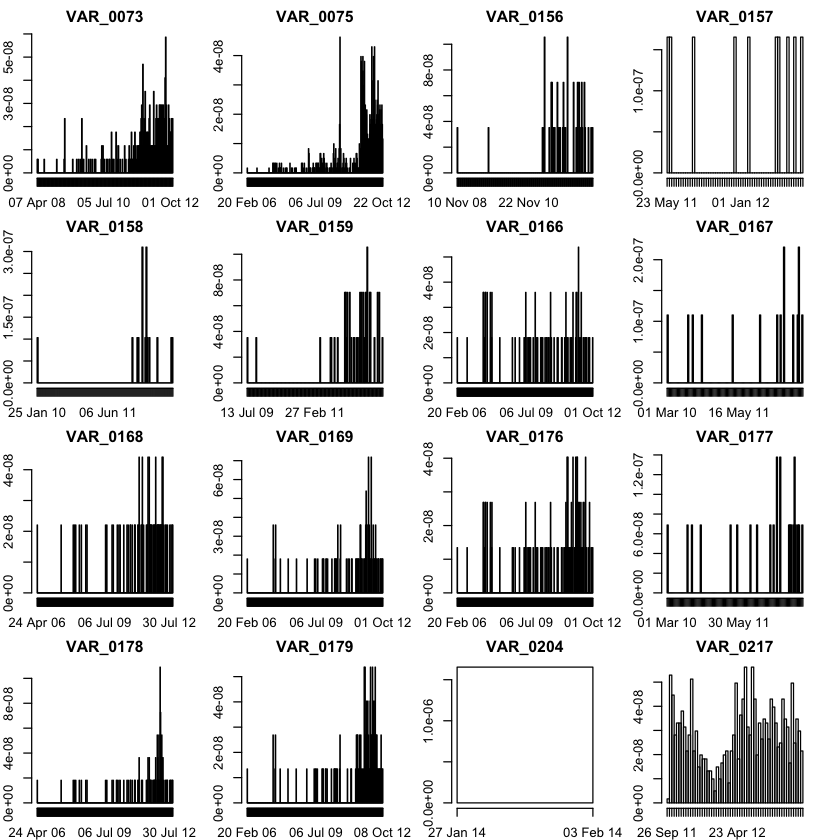

VAR_0073   VAR_0075   VAR_0156   VAR_0157   VAR_0158   VAR_0159   VAR_0166 
     0.718      0.000      0.953      0.990      0.984      0.953      0.908 
  VAR_0167   VAR_0168   VAR_0169   VAR_0176   VAR_0177   VAR_0178   VAR_0179 
     0.985      0.925      0.908      0.877      0.976      0.909      0.877 
  VAR_0204   VAR_0217 VAR_0204_h VAR_0217_h 
     0.000      0.000      0.000      0.000

    VAR_0075             VAR_0204             VAR_0217            VAR_0204_h   
 Min.   :2006-02-23   Min.   :2014-01-30   Min.   :2011-10-02   Min.   : 0.00  
 1st Qu.:2011-07-19   1st Qu.:2014-01-30   1st Qu.:2011-12-24   1st Qu.:16.00  
 Median :2011-12-27   Median :2014-01-31   Median :2012-05-15   Median :19.00  
 Mean   :2011-09-04   Mean   :2014-01-31   Mean   :2012-04-25   Mean   :17.62  
 3rd Qu.:2012-06-05   3rd Qu.:2014-02-01   3rd Qu.:2012-08-04   3rd Qu.:22.00  
 Max.   :2012-11-01   Max.   :2014-02-01   Max.   :2012-11-01   Max.   :23.00  
                                                                               
   VAR_0217_h     VAR_0075_d     VAR_0204_d      VAR_0217_d    VAR_0075_w   
 Min.   :2    Friday   :166   Friday  :375   Friday   :158   Min.   : 1.00  
 1st Qu.:2    Monday   : 72   Saturday:365   Monday   : 40   1st Qu.:20.00  
 Median :2    Saturday :137   Thursday:260   Saturday :160   Median :32.00  
 Mean   :2    Sunday   : 34                  Sunday 

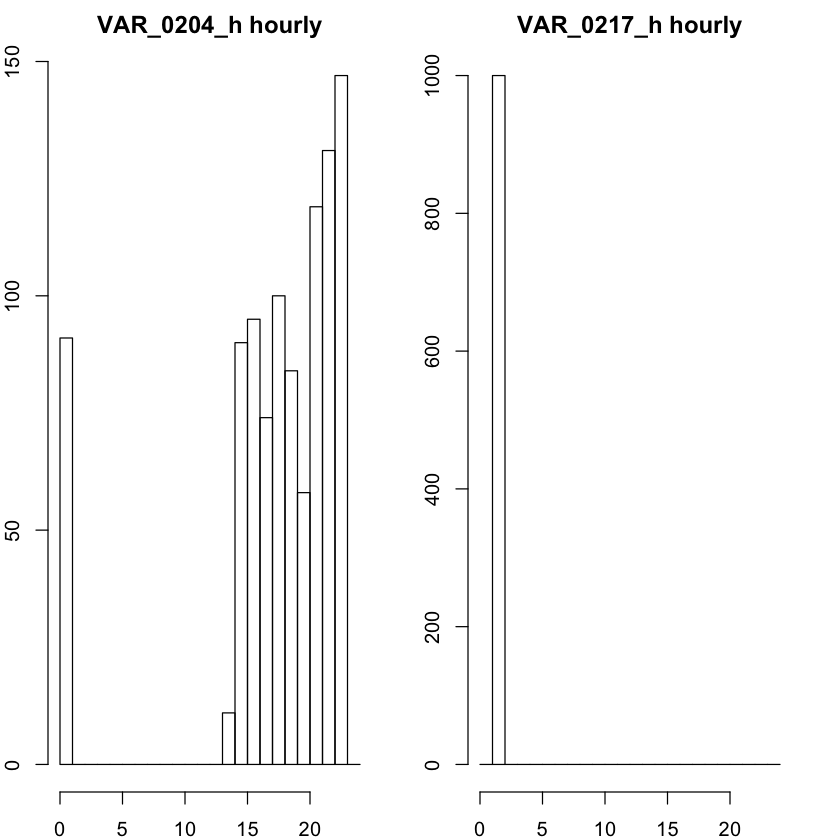

In [8]:
# ------------------------- time variables ------------------------------
# Now lets separate out the dates from the character columns and look at them further.
# which features are times features
time_featureval = grep("JAN1|FEB1|MAR1", train);
time_feature = names(train)[time_featureval]
train_time = train[,time_featureval]
train = subset(train, select = -time_featureval)

train_time = do.call(cbind.data.frame,
  sapply(train_time, function(x) strptime(x, "%d%B%y:%H:%M:%S")))

# Take out the times to a different data frame.
train_time[,c("VAR_0204_h","VAR_0217_h")] = train_time[, c("VAR_0204","VAR_0217")]
train_time[,c("VAR_0204_h","VAR_0217_h")] = sapply(train_time[,c("VAR_0204_h","VAR_0217_h")], function(x) as.numeric(format(x, "%H")))

# Plot histogram of dates.
par(mar=c(2,2,2,2),mfrow=c(4,4))
for(i in 1:16) hist(train_time[,time_feature[i]], "weeks", format = "%d %b %y", 
                    main = time_feature[i], xlab="", ylab="")

# Plot histogram of times.
par(mar=c(2,2,2,2),mfrow=c(1,2))
for(i in 1:2) hist(train_time[,c("VAR_0204_h","VAR_0217_h")[i]], 
                   main = paste(c("VAR_0204_h","VAR_0217_h")[i], "hourly"), 
                   breaks = c(0:24), xlab="", ylab="")

# proportion of missing values
colSums(is.na(train_time)) / nrow(train_time)
# only retain VAR_0075, VAR_0204, VAR_0217, VAR_0204_h, VAR_0217_h
train_time = train_time[,c("VAR_0075", "VAR_0204", "VAR_0217", "VAR_0204_h", "VAR_0217_h")]
train_time[,c("VAR_0075", "VAR_0204", "VAR_0217")] = 
  lapply(train_time[,c("VAR_0075", "VAR_0204", "VAR_0217")],as.Date)

train_time[,c("VAR_0075_d", "VAR_0204_d", "VAR_0217_d")] = 
  lapply(train_time[,c("VAR_0075", "VAR_0204", "VAR_0217")],weekdays)

train_time[,c("VAR_0075_w", "VAR_0204_w", "VAR_0217_w")] = 
  lapply(train_time[,c("VAR_0075", "VAR_0204", "VAR_0217")], function(x) as.numeric(format(x, "%U")))

train_time[,c("VAR_0075_m", "VAR_0204_m", "VAR_0217_m")] = 
  lapply(train_time[,c("VAR_0075", "VAR_0204", "VAR_0217")],months)

train_time[sapply(train_time, is.character)] <- lapply(train_time[sapply(train_time, is.character)], as.factor)

summary(train_time)



Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or 'news(package="maps")'.  #




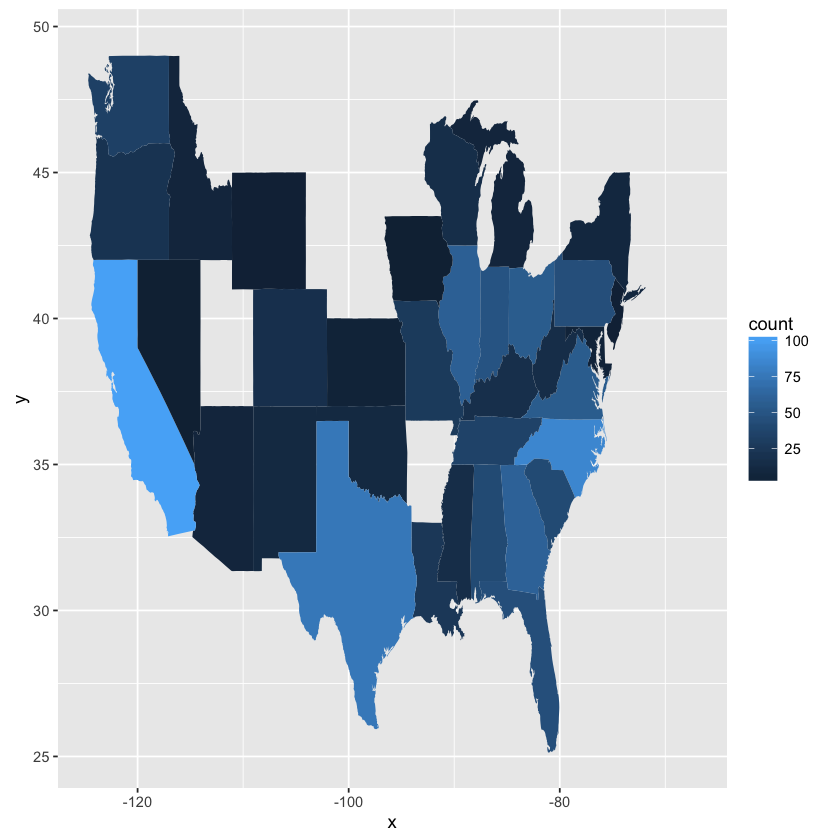

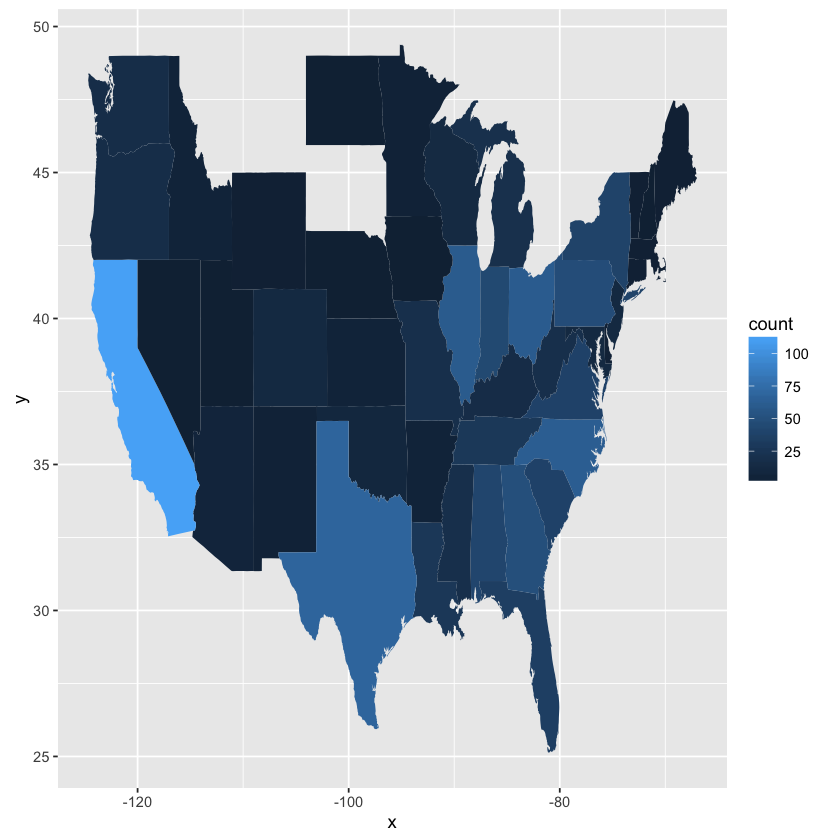

In [9]:
# -------------------- geographical variables -------------------------------
# Here we take a look at the geographical break down of the state features.
require(dplyr)
var0237 <- train %>% group_by(VAR_0237) %>% summarise(count = n())
var0237$name <- tolower(state.name[sapply(var0237$VAR_0237, grep, state.abb)])

require(ggplot2)
states_map <- map_data("state")
ggplot(var0237, aes(map_id = name)) + 
  geom_map(aes(fill = count), map = states_map) +
  expand_limits(x = states_map$long, y = states_map$lat)

# do the same for VAR_0274
# world_map <- map_data("world")
var0274 <- train %>% group_by(VAR_0274) %>% summarise(count = n())
var0274 <- subset(var0274, !is.na(var0274$VAR_0274))
var0274 <- subset(var0274, VAR_0274 %in% state.abb)
var0274$name <- tolower(state.name[sapply(var0274$VAR_0274, grep, state.abb)])

ggplot(var0274, aes(map_id = name)) + 
  geom_map(aes(fill = count), map = states_map) +
  expand_limits(x = states_map$long, y = states_map$lat)

rm(states_map)

In [10]:
# ------------------ proportion of NA values ------------------
p_na = colSums(is.na(train)) / nrow(train)
na_index = which(p_na > .7)
train = train[, -na_index]

 VAR_0001 VAR_0005  VAR_0008     VAR_0009     VAR_0010     VAR_0011   
 H:442    B:494    false:1000   false:1000   false:1000   false:1000  
 Q:  2    C:373                                                       
 R:556    N:119                                                       
          S: 14                                                       
                                                                      
                                                                      
                                                                      
  VAR_0012     VAR_0043     VAR_0196            VAR_0200           VAR_0202   
 false:1000   false:1000   false:1000   CHICAGO     : 16   BatchInquiry:1000  
                                        HOUSTON     :  9                      
                                        COLUMBUS    :  8                      
                                        DENVER      :  8                      
                                     

 VAR_0001 VAR_0005         VAR_0200    VAR_0226    VAR_0230    VAR_0232  
 H:442    B:494    CHICAGO     : 16   false:996   false:999   false:403  
 Q:  2    C:373    HOUSTON     :  9   true :  4   true :  1   true :597  
 R:556    N:119    COLUMBUS    :  8                                      
          S: 14    DENVER      :  8                                      
                   FAYETTEVILLE:  8                                      
                   INDIANAPOLIS:  7                                      
                   (Other)     :944                                      
  VAR_0236      VAR_0237      VAR_0274     VAR_0283     VAR_0305  
 false:  1   CA     :101   CA     :111   F     :  1   H     :178  
 true :999   NC     : 85   TX     : 68   H     :180   P     : 52  
             TX     : 75   NC     : 62   P     :  2   R     :  2  
             GA     : 60   OH     : 61   R     :  3   S     :749  
             IL     : 58   IL     : 60   S     :777   unkown: 19  
      

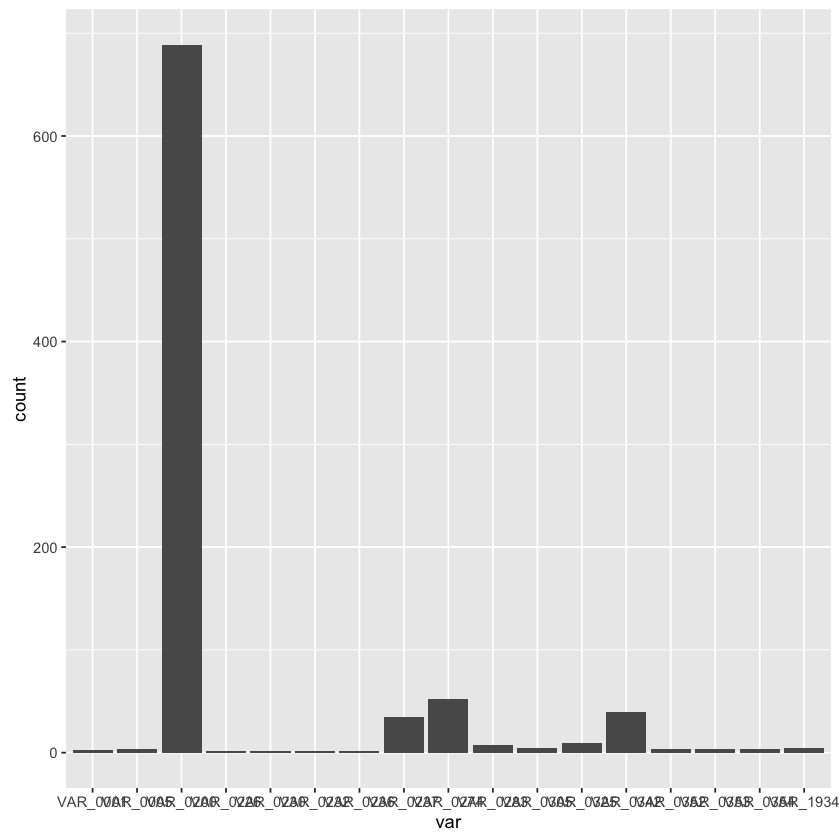

In [11]:
# ------------ number of unique values for each categorical variable ------------
train_char = names(train)[sapply(train, is.character) == TRUE]
# drop variables with unique values
train_unique = names(train[,train_char])[sapply(train[,train_char], function(x) length(unique(x))==1)]

# replace NA values with unkown 
for (var in train_char) {
  train[,train_char][,var][is.na(train[,train_char][,var])] = "unkown"
}

# change characters to factors
train[,train_char][sapply(train[,train_char], is.character)] <- 
  lapply(train[,train_char][sapply(train[,train_char], is.character)], as.factor)

summary(train[,train_char])

# drop variables with unique values
unique_feature = sapply(train,function(x) length(unique(x))>1)
train = train[,unique_feature]

train_char = names(train)[sapply(train, is.factor) == TRUE]
summary(train[,train_char])


# lets plot the unique values per feature
char_ct = data.frame(var = train_char, 
                     count = sapply(train[,train_char], 
                                    function(x) length(unique(x))))

ggplot(char_ct, aes(x = var, y = count)) + geom_bar(stat="identity") 
# g2 = ggplot(train_char, aes(x = count, fill=type)) +  
#   geom_histogram(binwidth = 100, alpha=0.7, position="identity") + 
#   xlab("Unique values per feature(101+)")  + xlim(c(101,nrow(train))) +
#   theme(axis.title.x=element_text(size=14, ,face="bold"))
# grid.arrange(g1, g2, ncol=2)
rm(char_ct)

In [12]:
# --------------- Now we drill down on the numerical values. ---------
train_numr = names(train)[sapply(train, is.numeric)]

# look at unique values
unique_feature = which(sapply(train[,train_numr], function(x) length(unique(x))==1))
unique_feature

# ------------ visualize numeric features
dev.off()
boxplot(train[,train_numr[1:20]])

# We shall impute -99999999 to the missing values and check for non-unique columns
# fill in NA values
sum(is.na(train[,train_numr]))
for (var in train_numr) {
  train[,var][is.na(train[,var])] = -99999999
}

named integer(0)

null device 
          1

[1] 1472

In [16]:
# ---------------------------------------------------------------
# We randomly sample the rows to look at.
set.seed(200)
train_numr_samp = sample(train_numr,100)

str(lapply(train[,train_numr_samp], unique))

#compute the correlation matrix
descrCor_pear <- cor(scale(train[,train_numr_samp],center=TRUE,scale=TRUE), method="pearson")
descrCor_spea <- cor(scale(train[,train_numr_samp],center=TRUE,scale=TRUE), method="spearman")

List of 100
 $ VAR_1079: int [1:29] 0 1 999 3 10 2 7 20 6 14 ...
 $ VAR_1170: int [1:112] 9999 85 48 64 43 109 96 89 19 54 ...
 $ VAR_1180: int [1:979] 76857 341365 107267 47568 23647 21139 327744 4326 27128 1197 ...
 $ VAR_1365: int [1:17] 0 2 1 4 99 98 5 11 6 97 ...
 $ VAR_1321: int [1:479] 30537 59 999999997 14 520 88 157 999999996 0 118 ...
 $ VAR_1635: int [1:9] 994 1 998 997 999 400 30 90 60
 $ VAR_1400: int [1:8] 1 998 120 30 999 400 60 90
 $ VAR_0264: num [1:3] 0e+00 -1e+08 1e+00
 $ VAR_1057: int [1:9] 0 3 1 99 2 97 4 5 7
 $ VAR_0529: num [1:2] 0e+00 -1e+08
 $ VAR_0929: int [1:68] 9996 64 50 9998 9999 51 12 1 25 40 ...
 $ VAR_1283: int [1:9] 0 97 2 99 98 1 4 3 6
 $ VAR_0376: num [1:5] 0e+00 1e+00 3e+00 -1e+08 2e+00
 $ VAR_1282: int [1:14] 0 1 2 6 4 99 98 5 3 12 ...
 $ VAR_0796: int [1:25] 3 10 2 7 4 6 14 8 5 -99999 ...
 $ VAR_0658: int [1:9] 97 1 98 0 99 2 3 6 4
 $ VAR_1131: int [1:112] 999994 321 804 999999 632 358 54 534 866 1043 ...
 $ VAR_0331: num [1:413] 0 145199 68120 33

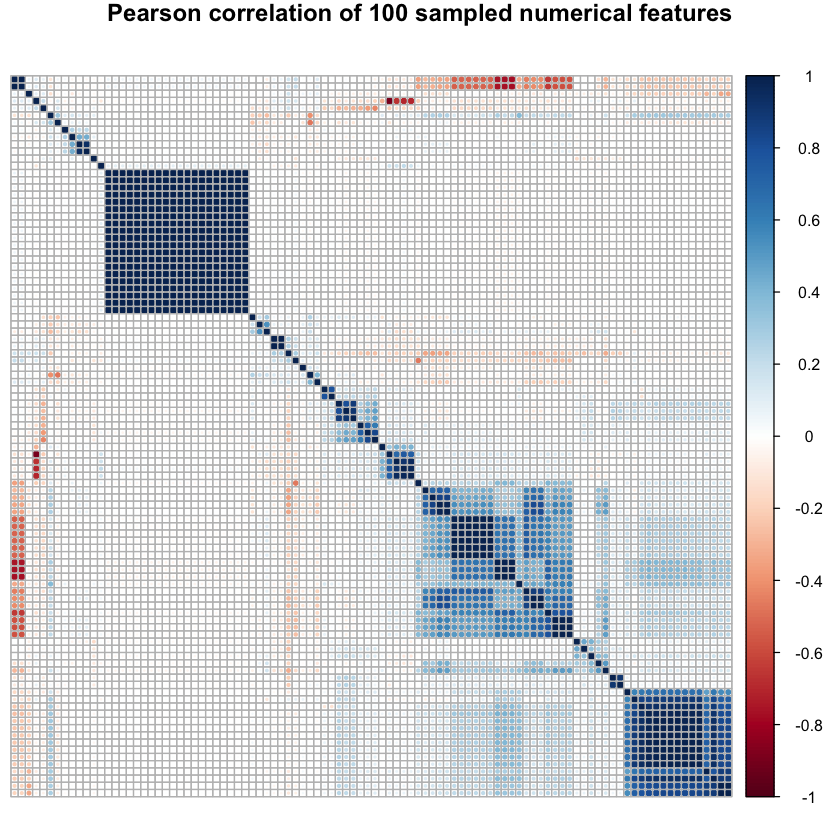

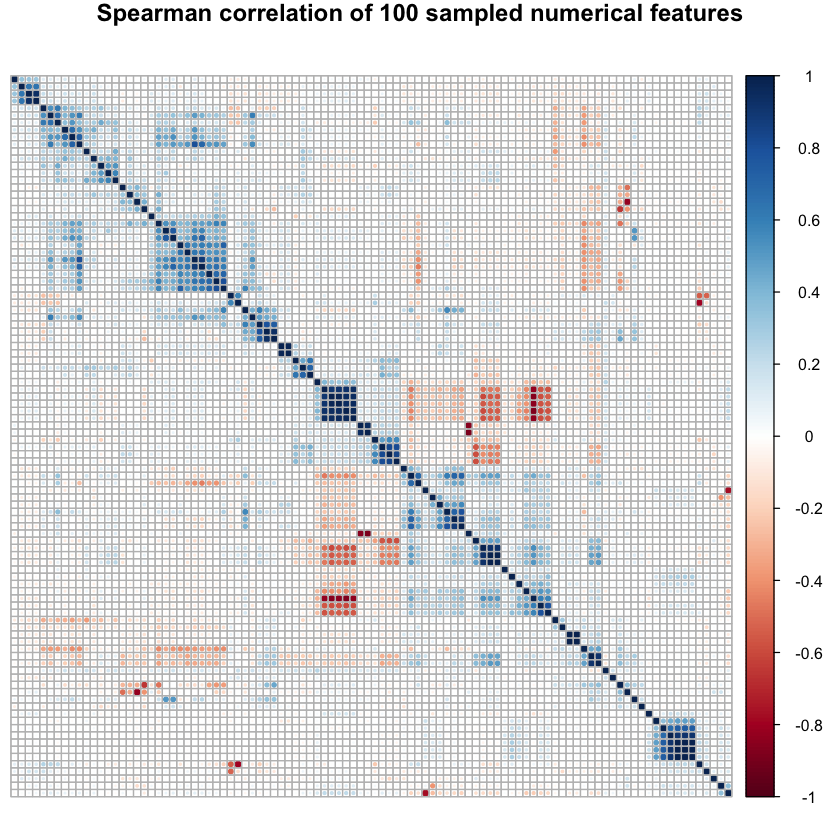

In [17]:
# Kendall takes to long to run
# descrCor_kend <-  cor(scale(train_numr_samp,center=TRUE,scale=TRUE), method="kendall")
# visualize the matrix, clustering features by correlation index.
require(corrplot)
corrplot(descrCor_pear, order = "hclust", mar=c(0,0,1,0), tl.pos="n", main="Pearson correlation of 100 sampled numerical features")
corrplot(descrCor_spea, order = "hclust", mar=c(0,0,1,0), tl.pos="n", main="Spearman correlation of 100 sampled numerical features")

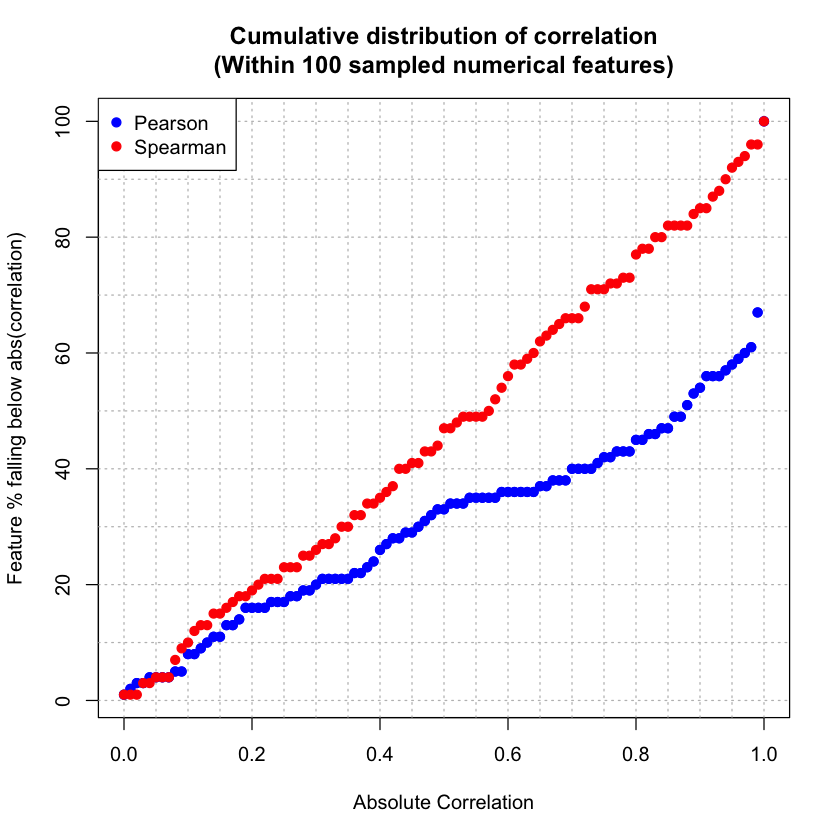

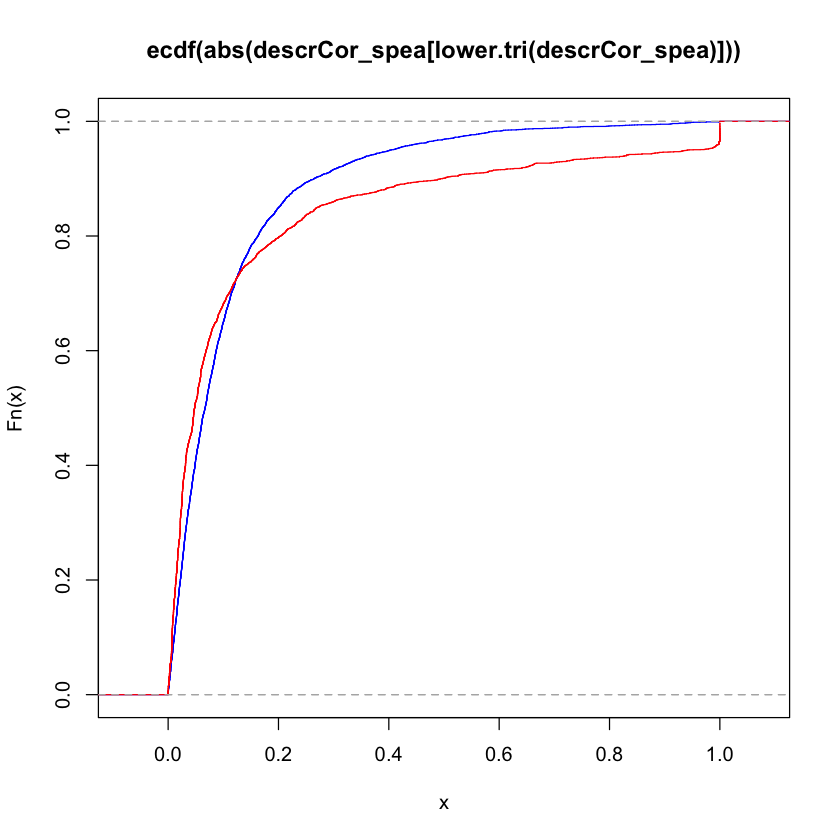

In [18]:
# Now lets check the cumulative distribution of correlation within these 100 sampled numericalcolumns. 
# The below plot shows the proportion of features containing a max correlation to another feature below 
# the correlation threshold.
corr.df = expand.grid(corr_limit=(0:100)/100, perc_feat_pear=NA, perc_feat_spea=NA)
require(caret)
for(i in 0:100){
  corr.df$perc_feat_pear[i+1]=length(findCorrelation(descrCor_pear, i/100))
  corr.df$perc_feat_spea[i+1]=length(findCorrelation(descrCor_spea, i/100))
}

plot(corr.df$corr_limit, abs(100-corr.df$perc_feat_pear), pch=19, col="blue",
     ylab = "Feature % falling below abs(correlation)", xlab="Absolute Correlation",
     main="Cumulative distribution of correlation\n(Within 100 sampled numerical features)")
abline(h=(0:10)*10, v=(0:20)*.05, col="gray", lty=3)
points(corr.df$corr_limit, abs(100-corr.df$perc_feat_pear), pch=19, col="blue")
points(corr.df$corr_limit, abs(100-corr.df$perc_feat_spea), pch=19, col="red")
legend("topleft", c("Pearson", "Spearman"), col = c("blue", "red"), pch = 19, bg="white")

# empirical cdf of correlations
epear = ecdf(abs(descrCor_spea[lower.tri(descrCor_spea)]))
espea = ecdf(abs(descrCor_pear[lower.tri(descrCor_pear)]))
plot(epear,col="blue")
lines(espea,col="red")

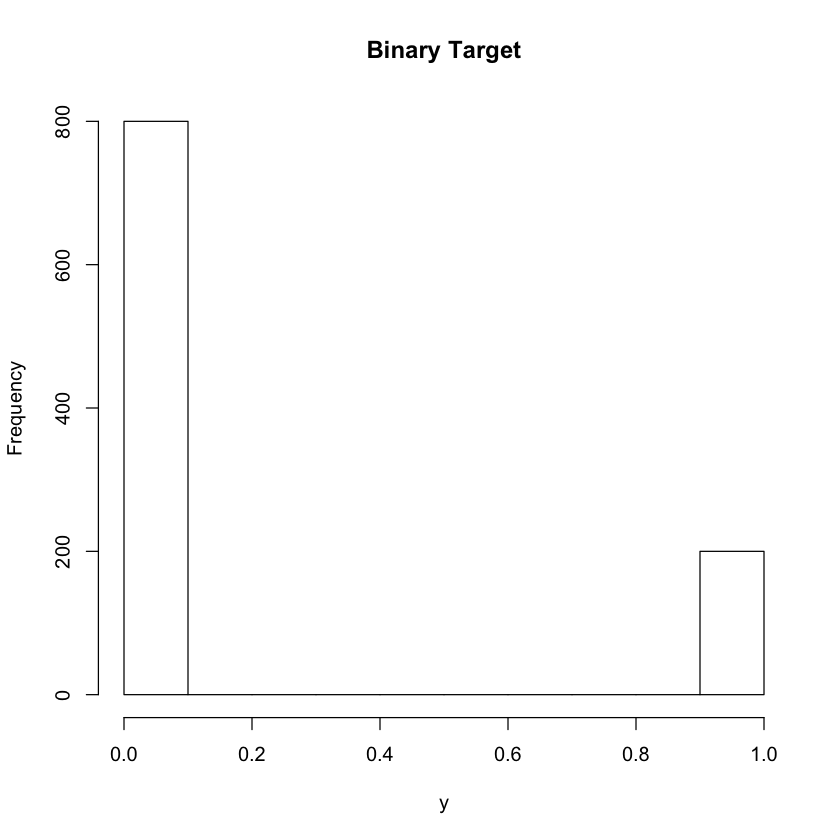

In [19]:
# -------------------- Finally lets take a look at our target.--------------------
hist(y, main="Binary Target")